In [ ]:
from matplotlib import pyplot as plt
import cv2
import os
import numpy as np
import torch
import torchvision

In [ ]:
!mkdir training_data
!mkdir training_data/bear
!mkdir training_data/snail

mkdir: cannot create directory ‘training_data’: File exists
mkdir: cannot create directory ‘training_data/bear’: File exists
mkdir: cannot create directory ‘training_data/snail’: File exists


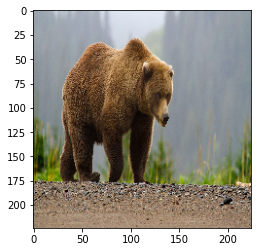

In [ ]:
x = cv2.imread('/content/training_data/bear/0.jpg')
x = cv2.cvtColor(x,cv2.COLOR_BGR2RGB) 
x = cv2.resize(x,(224,224)) 
plt.imshow(x)

In [ ]:
def read_image_file(f): 
  x = cv2.imread(f)
  x = cv2.cvtColor(x,cv2.COLOR_BGR2RGB) 
  x = cv2.resize(x,(224,224))
  return x

In [ ]:
bear_imgs = []
for f in os.listdir('training_data/bear/'):
  img_bear = read_image_file('training_data/bear/' +f)
  bear_imgs.append(img_bear)

In [ ]:
snail_imgs =[]
for f in os.listdir('training_data/snail/'):
  img_snail = read_image_file('training_data/snail/'+f)
  snail_imgs.append(img_snail)

In [ ]:
print('we have %d bear images and %d snail images' % (len(bear_imgs),len(snail_imgs)))

we have 11 bear images and 10 snail images


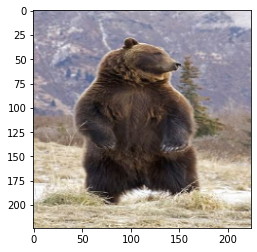

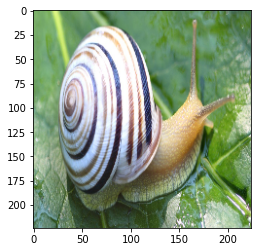

In [ ]:
plt.imshow(bear_imgs[3]);
plt.show();
plt.imshow(snail_imgs[2]);
plt.show();

In [ ]:
img_model = torchvision.models.resnet18(pretrained=True,progress=True)
img_model.fc =torch.nn.Linear(512,2) 

In [ ]:
x = bear_imgs[0]
x = np.stack([x]) / 255.0 
x = torch.from_numpy(x).float()
x = x.permute([0, 3, 1, 2]) 

img_model.forward(x)

tensor([[0.0147, 0.8566]], grad_fn=<AddmmBackward>)

In [ ]:
result = img_model.forward(x)

In [ ]:
result.shape

torch.Size([1, 2])

In [ ]:
img_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
result

tensor([[0.0147, 0.8566]], grad_fn=<AddmmBackward>)

In [ ]:
def convert_imgs_to_torch_sensor(imgs):
  x = np.stack(imgs) / 255.0 
  x = torch.from_numpy(x).float()
  x = x.permute([0, 3, 1, 2]) 
  return x

In [ ]:
result = img_model.forward(convert_imgs_to_torch_sensor(snail_imgs))

In [ ]:
result.shape 

torch.Size([10, 2])

In [ ]:
result 

tensor([[ 0.5319,  0.6815],
        [-0.3935,  1.4404],
        [-0.0785,  1.0924],
        [-0.9519,  0.9724],
        [-0.0650,  0.4904],
        [-0.5696,  1.0341],
        [-0.0791,  0.7476],
        [-0.1208,  0.7768],
        [ 1.2786,  0.4458],
        [ 0.3454,  0.1028]], grad_fn=<AddmmBackward>)

# Training Model

In [ ]:
train_images =[]
train_labels = []

for img in bear_imgs:
  train_images.append(img)
  train_labels.append(0)

for img in snail_imgs:
  train_images.append(img)
  train_labels.append(1)

In [ ]:
optimizer = torch.optim.SGD(
    img_model.parameters(),
    lr=0.01
)

In [ ]:
for it in range(7):
  optimizer.zero_grad()
  img_model.train(True)
  result = img_model.forward(convert_imgs_to_torch_sensor(train_images))
  loss = torch.nn.functional.cross_entropy(result,torch.from_numpy(np.stack(train_labels)))
  print('Iteration',it,'loss value',float(loss))
  loss.backward()
  optimizer.step()

Iteration 0 loss value 0.32422712445259094
Iteration 1 loss value 0.17993886768817902
Iteration 2 loss value 0.12332914024591446
Iteration 3 loss value 0.0937943309545517
Iteration 4 loss value 0.07554808259010315
Iteration 5 loss value 0.06317570805549622
Iteration 6 loss value 0.05424823239445686


In [ ]:
result.shape

torch.Size([21, 2])

In [ ]:
img_model.train(False)
result = img_model.forward(convert_imgs_to_torch_sensor(bear_imgs))
result.shape

torch.Size([11, 2])

In [ ]:
result

tensor([[ 2.5894, -0.9971],
        [ 2.1263, -1.5004],
        [ 1.9791, -1.2526],
        [ 1.6607, -1.4430],
        [ 1.9901, -1.5764],
        [ 2.1987, -1.1724],
        [ 2.2633, -1.3828],
        [ 2.3873, -1.0651],
        [ 2.4876, -1.0046],
        [ 3.2165, -0.9397],
        [ 2.3888, -0.8238]], grad_fn=<AddmmBackward>)

# Deploy Model / Testing

In [ ]:
!wget 'https://upload.wikimedia.org/wikipedia/commons/thumb/7/71/2010-kodiak-bear-1.jpg/1200px-2010-kodiak-bear-1.jpg'

--2021-08-26 10:31:43--  https://upload.wikimedia.org/wikipedia/commons/thumb/7/71/2010-kodiak-bear-1.jpg/1200px-2010-kodiak-bear-1.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 91.198.174.208, 2620:0:862:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|91.198.174.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 215129 (210K) [image/jpeg]
Saving to: ‘1200px-2010-kodiak-bear-1.jpg’

1200px-2010-kodiak- 100%[===================>] 210.09K  --.-KB/s    in 0.02s   

2021-08-26 10:31:43 (13.0 MB/s) - ‘1200px-2010-kodiak-bear-1.jpg’ saved [215129/215129]



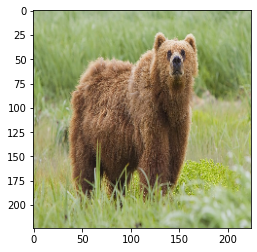

In [ ]:
x = read_image_file('1200px-2010-kodiak-bear-1.jpg')
plt.imshow(x)

In [ ]:
img_model.train(False)
result= img_model.forward(convert_imgs_to_torch_sensor([x]))
print(result)
if float(result[0,0])> float(result[0,1]):
  print('it is a bear!!')
else:
  print('it is a snail')  

tensor([[ 1.9791, -1.2526]], grad_fn=<AddmmBackward>)
it is a bear!!


In [ ]:
!wget 'https://www.papo-france.com/1233-thickbox_default/snail.jpg'

--2021-08-26 10:35:26--  https://www.papo-france.com/1233-thickbox_default/snail.jpg
Resolving www.papo-france.com (www.papo-france.com)... 51.38.50.194
Connecting to www.papo-france.com (www.papo-france.com)|51.38.50.194|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 212282 (207K) [image/jpeg]
Saving to: ‘snail.jpg’

snail.jpg           100%[===================>] 207.31K  --.-KB/s    in 0.05s   

2021-08-26 10:35:26 (3.87 MB/s) - ‘snail.jpg’ saved [212282/212282]



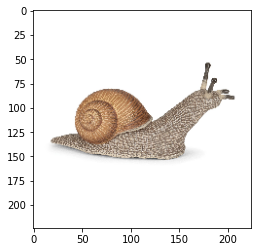

In [ ]:
y= read_image_file('snail.jpg')
plt.imshow(y)

In [ ]:
img_model.train(False)
result= img_model.forward(convert_imgs_to_torch_sensor([y]))
print(result)
if float(result[0,0])> float(result[0,1]):
  print('it is a bear!!')
else:
  print('it is a snail!!') 

tensor([[-0.1548,  1.4747]], grad_fn=<AddmmBackward>)
it is a snail!!
